In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from functools import partial

import numpy as np
import torch
from torch.utils.data import DataLoader

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from IPython.display import display

from tqdm import tqdm_notebook as tqdm

import gmmn as G
from gmmn.utils import pil

In [2]:
featurizer = G.featurize.make_featurizer(
    G.featurize.load_smoothing_imagenet_model("/nfs/nhome/live/dougals/smoothing/models/imagenet/resnet50/noise_0.25/checkpoint.pth.tar"),
    kind='through'
).cuda()

In [3]:
def kernel(X, Y):
    X = torch.as_tensor(X, device='cuda')
    Y = torch.as_tensor(Y, device='cuda')
    return G.kernels.linear(featurizer(X), featurizer(Y))

In [4]:
make_celeba = partial(
    G.datasets.CelebA,
    path="/nfs/data/dougals/celeba/",
    transform=G.datasets.celeba_transform(out_size=64),
)


def get_batch(batch_size, ds=None, **kwargs):
    if ds is None:
        ds = make_celeba(**kwargs)
    else:
        assert not kwargs
    return next(
        iter(DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=True))
    )


def est_mmd2(
    q1, q2=None, batch_size=256, show=True, add_noise=0, permute=500, estimator=None
):
    if q2 is None:
        q2 = f"not ({q1})"

    b1, _ = get_batch(attr_query=q1, batch_size=batch_size)
    b2, _ = get_batch(attr_query=q2, batch_size=batch_size)

    if add_noise:
        b1 = b1 + torch.randn_like(b1) * add_noise
        b2 = b2 + torch.randn_like(b2) * add_noise

    if show:
        display(pil(b1[:8]))
        display(pil(b2[:8]))

    kw = {"kernel_pair": kernel(b1, b2)}
    if estimator is not None:
        kw["estimator"] = estimator

    if not permute:
        return G.mmd.mmd2(**kw).item()
    else:
        est, p_val, rest = G.mmd.mmd2_permutations(permutations=permute, **kw)
        rest = rest.cpu().numpy()

        if show:
            fig, ax = plt.subplots()
            ax.hist(rest, bins="auto", histtype="stepfilled", density=True)
            ax.axvline(est)
            ax.set_title(f"est: {est:,.0f}; $p$-value: {p_val:.0%}")
            display(fig)
            plt.close(fig)
        return est, p_val

In [5]:
make_celeba().attr_names

['5_o_Clock_Shadow',
 'Arched_Eyebrows',
 'Attractive',
 'Bags_Under_Eyes',
 'Bald',
 'Bangs',
 'Big_Lips',
 'Big_Nose',
 'Black_Hair',
 'Blond_Hair',
 'Blurry',
 'Brown_Hair',
 'Bushy_Eyebrows',
 'Chubby',
 'Double_Chin',
 'Eyeglasses',
 'Goatee',
 'Gray_Hair',
 'Heavy_Makeup',
 'High_Cheekbones',
 'Male',
 'Mouth_Slightly_Open',
 'Mustache',
 'Narrow_Eyes',
 'No_Beard',
 'Oval_Face',
 'Pale_Skin',
 'Pointy_Nose',
 'Receding_Hairline',
 'Rosy_Cheeks',
 'Sideburns',
 'Smiling',
 'Straight_Hair',
 'Wavy_Hair',
 'Wearing_Earrings',
 'Wearing_Hat',
 'Wearing_Lipstick',
 'Wearing_Necklace',
 'Wearing_Necktie',
 'Young']

['Young', 0]

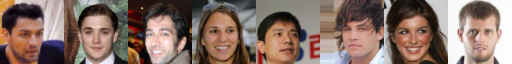

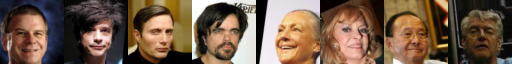

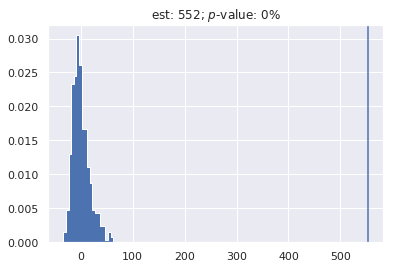

['Young', 0.25]

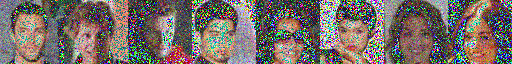

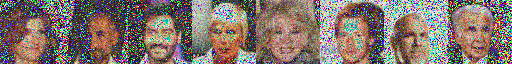

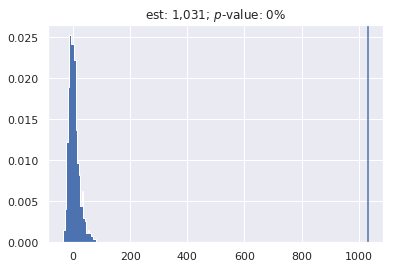

['Male', 0]

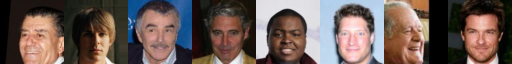

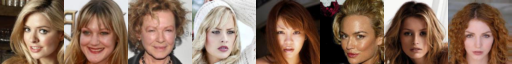

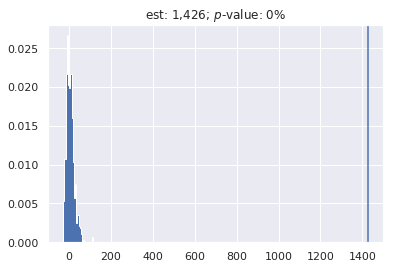

['Male', 0.25]

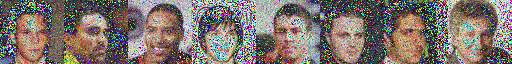

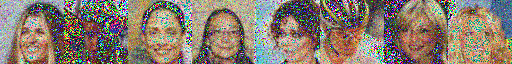

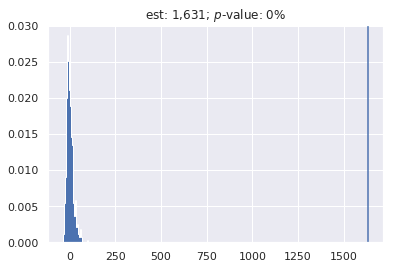

['Attractive', 0]

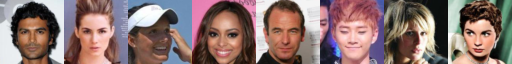

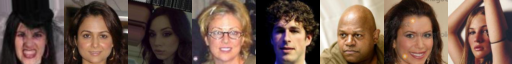

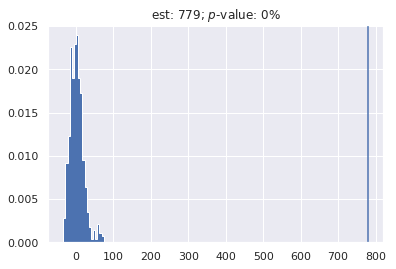

['Attractive', 0.25]

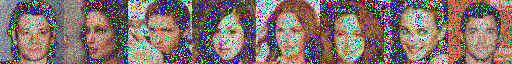

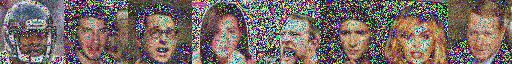

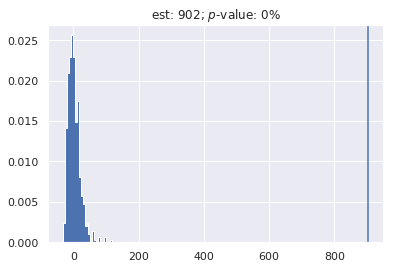

['Straight_Hair', 0]

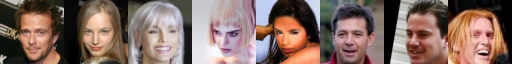

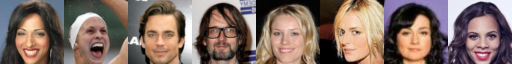

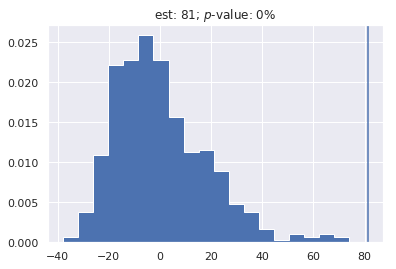

['Straight_Hair', 0.25]

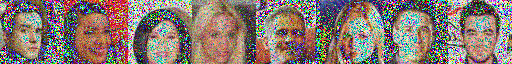

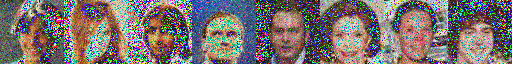

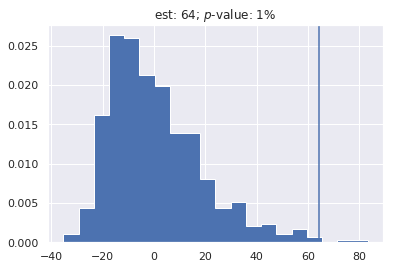

['Male and No_Beard', 'Male and not No_Beard', 0]

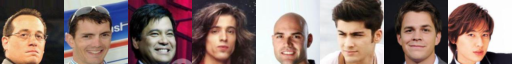

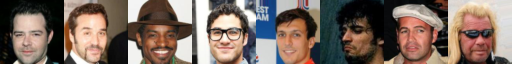

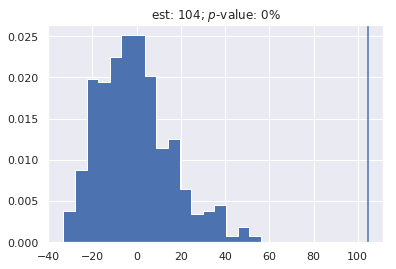

['Male and No_Beard', 'Male and not No_Beard', 0.25]

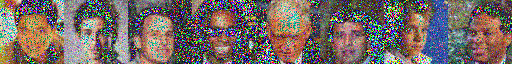

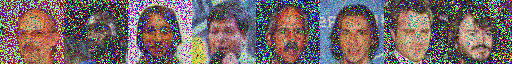

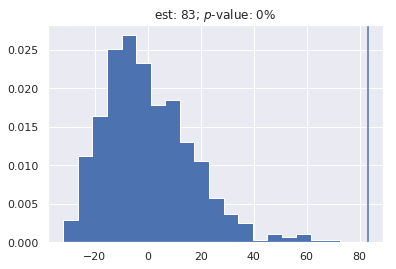

['Pale_Skin', 0]

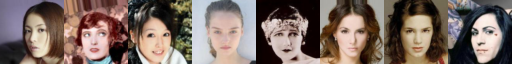

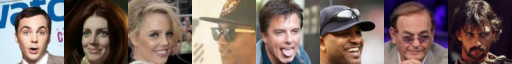

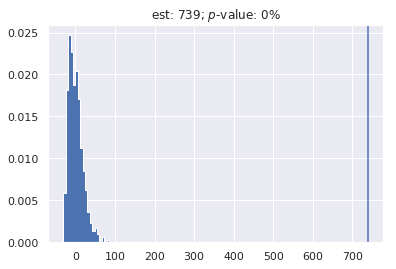

['Pale_Skin', 0.25]

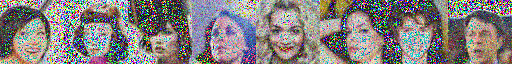

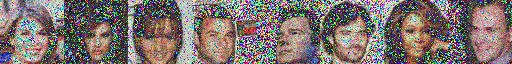

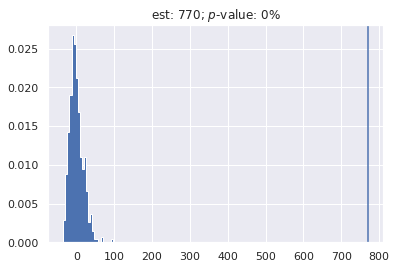

['not Male and Young and Attractive and Wearing_Lipstick',
 'not Male and Young and Attractive and not Wearing_Lipstick',
 0]

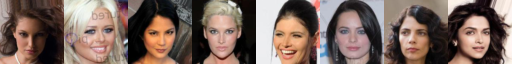

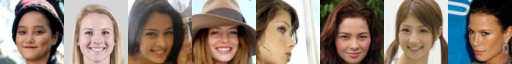

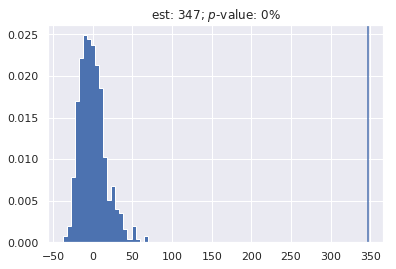

['not Male and Young and Attractive and Wearing_Lipstick',
 'not Male and Young and Attractive and not Wearing_Lipstick',
 0.25]

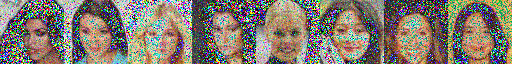

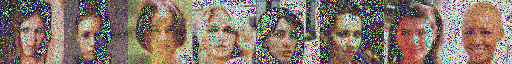

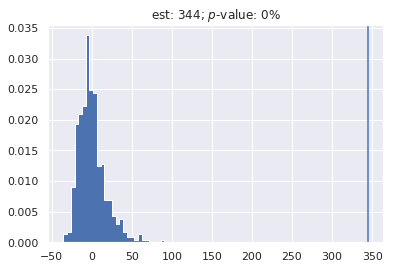

In [6]:
for comp in tqdm([
    ['Young'],
    ['Male'],
    ['Attractive'],
    ['Straight_Hair'],
    ['Male and No_Beard', 'Male and not No_Beard'],
    ['Pale_Skin'],
    ['not Male and Young and Attractive and Wearing_Lipstick', 'not Male and Young and Attractive and not Wearing_Lipstick'],
]):
    for noise in [0, 0.25]:
        display(comp + [noise])
        est_mmd2(*comp, add_noise=noise)